# Getting Started

In this notebook, we have developed code the show a full example of usage of the UnnobservedComponentsGAS.jl package.

## Import packages

In [ ]:
import Pkg
Pkg.add(url = "https://github.com/LAMPSPUC/UnobservedComponentsGAS.git")

using UnobservedComponentsGAS, Plots, CSV, DataFrames, Metrics

## Reading Airline Passengers data

First of all, one may want to visualize the time series data to be modeled and forecasted, while also leaving the last 12 timestamps as a validation set.

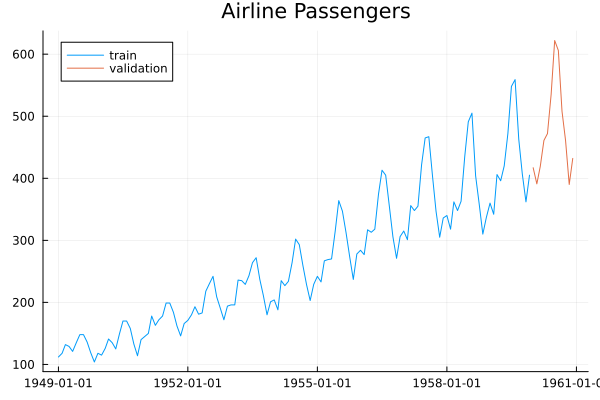

In [8]:
data = CSV.read("data/airline-passengers.csv", DataFrame)

steps_ahead = 12
y_train     = data[1:end-steps_ahead, 2]
y_val       = data[end-steps_ahead+1:end, 2] 
dates_train = data[1:end-steps_ahead, 1]
dates_val   = data[end-steps_ahead+1:end, 1]

plot(title = "Airline Passengers")
plot!(dates_train, y_train, label = "train")
plot!(dates_val, y_val, label = "validation")

## Define a Score-Driven Model

In order to create a GASModel object, one must specify some important informations, namely:
 - The model distribution;
 - Which parameters of the specified distribution will be time-varying;
 - The scale factor d to calculate the scaled score;
 - The level component dynamic for each parameter that is time-varying;
 - The seasonal component dynamic for each parameter that is time-varying, including the number seasonal periods;
 - The autoregressive component order for each parameter that is time-varying;

In thhe following example, we have created a GASModel with:
 - LogNormal distribution;
 - Only the first parameter as time-verying;
 - d = 1.0;
 - The level component as a random walk with slope;
 - The seasonal component as a deterministic seasonality with 12 seasonal periods;
 - No autoregressive component;

In [9]:
dist                    = UnobservedComponentsGAS.LogNormalDistribution()
time_varying_parameters = [true, false]
d                       = 1.0
level                   = ["random walk slope", ""]
seasonality             = ["deterministic 12", ""]
ar                      = [missing, missing]

model = UnobservedComponentsGAS.GASModel(dist, time_varying_parameters, d, level,seasonality, ar);

## Fit a GASModel model

In order to fit the model we have created, we must simply call the function *fit*, passing the model created, the time series we wish to fit, and some auxiliar parameters, if wanted, as sample robustness and regularization $\alpha$. 

In [ ]:
fitted_model = UnobservedComponentsGAS.fit(model, y_train; robust = false, α = 0.5);

In [22]:
fieldnames(typeof(fitted_model))

(:fit_in_sample, :fitted_params, :components, :selected_variables, :residuals, :information_criteria, :penalty_factor, :model_status)

The *fit* function returns a *Output* object that has the following fields and values:
 - :fit_in_sample: keeps the time series fitted values of the model
 - :fitted_params: keeps all the model's fitted params 
 - :components: keeps a dictionary with the fitted components of each time-varying parameter
 - :selected_variables: keeps the selected explanatory variables
 - :residuals: keeps a dictionary with the model's residuals
 - :information_criteria: keeps some informatin criteria, as the AIC and BIC
 - :penalty_factor: keep the regularization parameter $\alpha$
 - :model_status: keeps the optimization status

## Forecasting with the fitted model

In order to predict the future of the fitted model, we must use the function *predict*, passing the gas model, the fitted model, the vector of the fitted series, the number of steps ahead and the number of forecast scenarios. 

In [ ]:
steps_ahead    = 12
num_scenarious = 500
forec = UnobservedComponentsGAS.predict(model, fitted_model, Float64.(y_train), steps_ahead, num_scenarious);

println(keys(forec))

## Final coments

Since this is just a getting started example, we will finish after obtaining the forecasted values, however, we strongly recommend that you explore the other examples we have developed in order to dive deeply into the package features.